Join the data from Part 1 with the data from Part 2 to create a new dataframe.

In [61]:
import pandas as pd
import geopy # to retreive the postal code from latitude and longitude

bikes_df = pd.read_csv('bikes.csv', index_col=0)
FSQ_df = pd.read_csv('fsq.csv', index_col =0)
yelp_df = pd.read_csv('yelp.csv', index_col = 0)


In [64]:
#bikes_df.head()
#FSQ_df.head()
#yelp_df.head()

,latitude,longitude,free_bikes
0,43.665269,-79.319796,16
1,43.671420,-79.445947,0
2,43.666224,-79.317693,21
3,43.653236,-79.376716,0
4,43.663722,-79.380288,8


In [65]:
def get_postCode(df,lat, long): # function to retreive the postal code
    geo = geopy.Nominatim(user_agent='1234')
    location = geo.reverse((df[lat], df[long]))
    postCode = location[0].split(',')[-2]
    return postCode
bikes_df['postCode']= bikes_df.apply(get_postCode, axis=1, long='longitude',lat='latitude')

In [67]:
bikes_df.head()

,latitude,longitude,free_bikes,postCode
0,43.665269,-79.319796,16,M4L 1E2
1,43.671420,-79.445947,0,M6H 2C7
2,43.666224,-79.317693,21,M4L 3B2
3,43.653236,-79.376716,0,M5C 1R8
4,43.663722,-79.380288,8,M4Y 1X7


In [160]:
bikes_df['postCode'] = bikes_df['postCode'].str.strip()
bikes_df['postCode']= bikes_df['postCode'].str.split().agg("".join)

FSQ_df['postCode'] = FSQ_df['postCode'].str.strip()
FSQ_df['postCode']= FSQ_df['postCode'].str.split().agg("".join)

yelp_df['postCode'] = yelp_df['postCode'].str.strip()
yelp_df['postCode']= yelp_df['postCode'].str.split().agg("".join)



In [161]:
# 46 rows have no full postal code in bikee_df.
len(bikes_df[bikes_df['postCode'].str.len() < 4])

# zero rows have no full postal code in FSQ_df
len(FSQ_df[FSQ_df['postCode'].str.len() < 4])

#196 rows have no full postal code out of 8061 rows in yelp_df
len(yelp_df[yelp_df['postCode'].str.len() < 4])

# drop the rows that have no full postal code
bikes_df.drop(bikes_df[bikes_df['postCode'].str.len() < 4].index, inplace=True)
yelp_df.drop(yelp_df[yelp_df['postCode'].str.len() < 4].index, inplace=True) 

In [244]:
join_df = pd.merge(pd.merge(bikes_df,FSQ_df, on='postCode'),yelp_df, on='postCode')
join_df.head()
#len(join_df)

,latitude_x,longitude_x,free_bikes,postCode,POI_x,latitude_y,longitude_y,address,city_x,POI_y,rating,category1,category2,latitude,longitude,price,city_y,street
0,43.665269,-79.319796,16,M4L1E2,Diner,43.665121,-79.321347,"1483 Queen St E, Toronto ON M4L 1E2",Toronto,Chick-N-Joy,4.0,hotdogs,Fast Food,43.665090,-79.32132,$,Toronto,1483 Queen Street E
1,43.665269,-79.319796,16,M4L1E2,Diner,43.665121,-79.321347,"1483 Queen St E, Toronto ON M4L 1E2",Toronto,Chick-N-Joy,4.0,hotdogs,Fast Food,43.665090,-79.32132,$,Toronto,1483 Queen Street E
2,43.667214,-79.345270,14,M4M1Y5,Chinese Restaurant,43.666856,-79.345563,"797 Gerrard St E (at Logan Ave), Toronto ON M4...",Toronto,Hailed Coffee,4.5,coffee,Coffee & Tea,43.666880,-79.34538,$$,Toronto,801 Gerrard Street E
3,43.667214,-79.345270,14,M4M1Y5,Chinese Restaurant,43.666856,-79.345563,"797 Gerrard St E (at Logan Ave), Toronto ON M4...",Toronto,Hailed Coffee,4.5,coffee,Coffee & Tea,43.666880,-79.34538,$$,Toronto,801 Gerrard Street E
4,43.680916,-79.422968,6,M6G2N3,Ice Cream Parlor,43.682023,-79.419025,36 Vaughan Rd (btwn Ellsworth Ave. & Hocken Av...,Toronto,Dutch Dreams,4.0,icecream,Ice Cream & Frozen Yogurt,43.682045,-79.41892,$$,Toronto,36 Vaughan Road


In [245]:
# remove duplicate rows, before 51677 rows / after 1333 rows
join_df.drop_duplicates(inplace=True)
join_df.head()

,latitude_x,longitude_x,free_bikes,postCode,POI_x,latitude_y,longitude_y,address,city_x,POI_y,rating,category1,category2,latitude,longitude,price,city_y,street
0,43.665269,-79.319796,16,M4L1E2,Diner,43.665121,-79.321347,"1483 Queen St E, Toronto ON M4L 1E2",Toronto,Chick-N-Joy,4.0,hotdogs,Fast Food,43.665090,-79.32132,$,Toronto,1483 Queen Street E
2,43.667214,-79.345270,14,M4M1Y5,Chinese Restaurant,43.666856,-79.345563,"797 Gerrard St E (at Logan Ave), Toronto ON M4...",Toronto,Hailed Coffee,4.5,coffee,Coffee & Tea,43.666880,-79.34538,$$,Toronto,801 Gerrard Street E
4,43.680916,-79.422968,6,M6G2N3,Ice Cream Parlor,43.682023,-79.419025,36 Vaughan Rd (btwn Ellsworth Ave. & Hocken Av...,Toronto,Dutch Dreams,4.0,icecream,Ice Cream & Frozen Yogurt,43.682045,-79.41892,$$,Toronto,36 Vaughan Road
28,43.691067,-79.395350,0,M4T2S9,Fried Chicken Joint,43.689827,-79.395102,"1560 Yonge St (Heath St E), Toronto ON M4T 2S9",Toronto,Sushi Gen,3.0,sushi,Sushi Bars,43.689908,-79.39514,$$,Toronto,1560 Yonge Street
32,43.639832,-79.395954,29,M5V4A6,Café,43.640050,-79.396376,"66 Fort York Blvd (Fort York & Spadina), Toron...",Toronto,Hunters Landing,3.5,comfortfood,Comfort Food,43.640020,-79.39673,$$,Toronto,82 Fort York Blvd


In [163]:
#join_df.head()
join_df.columns
#join_df.city_y.unique()

Index(['latitude_x', 'longitude_x', 'free_bikes', 'postCode', 'POI_x',
       'latitude_y', 'longitude_y', 'address', 'city_x', 'POI_y', 'rating',
       'category1', 'category2', 'latitude', 'longitude', 'price', 'city_y',
       'street'],
      dtype='object')

In [246]:
#drop the unuseful columns
join_df.drop(['latitude_x', 'longitude_x', 'latitude_y','longitude_y','latitude','longitude','address'], axis=1, inplace=True)

In [166]:
#there are some difference between city_x and city_y columns, 181 rows

city_df = join_df.loc[join_df.city_x != join_df.city_y]
city_df[['city_x', 'city_y','street']]
#len(city_df)

,city_x,city_y,street
46668,East York,Toronto,2632 Danforth avenue
46669,East York,Toronto,2638 Danforth Avenue
46670,East York,Toronto,2750 Danforth Avenue
46671,East York,Toronto,2626 Danforth Ave
46672,East York,Toronto,2632 Danforth avenue
...,...,...,...
51609,Toronto,Aurora,4700 Keele Street
51614,Toronto,Aurora,4700 Keele Street
51619,Toronto,Aurora,4700 Keele Street
51624,Toronto,Aurora,4700 Keele Street


In [247]:
# update the city with the accurate city, e.g instead of Toronto, use East York

#tor_df = join_df.loc[join_df.city_x =='East York']
#tor_df[['city_x', 'city_y', 'address','street']]
join_df['city_x'] = join_df.apply(lambda x:x['city_y'] if x['city_x']=='Toronto' else x['city_x'], axis=1)
join_df['city_y'] = join_df.apply(lambda x:x['city_x'] if x['city_y']=='Toronto' else x['city_y'], axis=1)
join_df['city_y'].unique()

array(['Toronto', 'East York', 'Etobicoke', 'York', 'North York',
       'Aurora'], dtype=object)

In [256]:
# drop city_y, address columns and update the city and POI column names

join_df = join_df.rename({'city_x': 'city', 'POI_x': 'FSQ_POI', 'POI_y':'yelp_POI', 'category1':'category'}, axis=1)
#join_df.drop(['city_y'], axis=1, inplace=True)
#join_df.head()



In [249]:
# now let's work on the street column, we just need the street name

join_df['street'] = join_df['street'].replace('\d+','', regex=True)
join_df.head()

,free_bikes,postCode,FSQ_POI,city,yelp_POI,rating,category1,category2,price,street
0,16,M4L1E2,Diner,Toronto,Chick-N-Joy,4.0,hotdogs,Fast Food,$,Queen Street E
2,14,M4M1Y5,Chinese Restaurant,Toronto,Hailed Coffee,4.5,coffee,Coffee & Tea,$$,Gerrard Street E
4,6,M6G2N3,Ice Cream Parlor,Toronto,Dutch Dreams,4.0,icecream,Ice Cream & Frozen Yogurt,$$,Vaughan Road
28,0,M4T2S9,Fried Chicken Joint,Toronto,Sushi Gen,3.0,sushi,Sushi Bars,$$,Yonge Street
32,29,M5V4A6,Café,Toronto,Hunters Landing,3.5,comfortfood,Comfort Food,$$,Fort York Blvd


In [250]:
# put price in different categories [Inexpensive, Moderately, Expensive, Very Expensive] 

join_df.loc[join_df['price'] == '$', 'price'] = 'Inexpensive'
join_df.loc[join_df['price'] == '$$', 'price'] = 'Moderately'
join_df.loc[join_df['price'] == '$$$', 'price'] = 'Expensive'
join_df.loc[join_df['price'] == '$$$$', 'price'] = 'Very Expensive'

join_df.head()

,free_bikes,postCode,FSQ_POI,city,yelp_POI,rating,category1,category2,price,street
0,16,M4L1E2,Diner,Toronto,Chick-N-Joy,4.0,hotdogs,Fast Food,Inexpensive,Queen Street E
2,14,M4M1Y5,Chinese Restaurant,Toronto,Hailed Coffee,4.5,coffee,Coffee & Tea,Moderately,Gerrard Street E
4,6,M6G2N3,Ice Cream Parlor,Toronto,Dutch Dreams,4.0,icecream,Ice Cream & Frozen Yogurt,Moderately,Vaughan Road
28,0,M4T2S9,Fried Chicken Joint,Toronto,Sushi Gen,3.0,sushi,Sushi Bars,Moderately,Yonge Street
32,29,M5V4A6,Café,Toronto,Hunters Landing,3.5,comfortfood,Comfort Food,Moderately,Fort York Blvd


In [251]:
# Categories

join_df.loc[join_df['category'].isin(['sushi', 'japanese', 'thai', 'korean','chinese', 'vietnamese','dimsum', 'asianfusion', 'noodles', 'indpak', 'ramen', 'himalayan']), 'category1'] = 'Asian'
join_df.loc[join_df['category'].isin(['mediterranean', 'mideastern', 'lebanese']), 'category1'] = 'MiddleEast'
join_df.loc[join_df['category'].isin(['french', 'portuguese' , 'greek', 'polish', 'russian','italian', 'tapas']), 'category1'] = 'Europe'
join_df.loc[join_df['category'].isin(['peruvian', 'mexican','caribbean', 'cuban', 'newcanadian', 'latin', 'hawaiian']), 'category1'] = 'American'
join_df.loc[join_df['category'].isin(['pizza', 'bagels', 'burgers', 'chicken_wings','sandwiches', 'hotdogs','icecream','bakeries','comfortfood','vegan','salad','breakfast_brunch','seafood','chickenshop','diners','tapasmallplates','delis']), 'category1'] = 'FastFood'
join_df.loc[join_df['category'].isin(['cafes', 'coffeeroasteries', 'coffee','chocolate','desserts',]), 'category1'] = 'Cafe'
join_df.loc[join_df['category'].isin(['pubs', 'gastropubs', 'cocktailbars', 'wine_bars', 'bars', 'beer_and_wine', 'breweries','lounges','tikibars']), 'category1'] = 'Bars'
join_df.loc[join_df['category'].isin(['steak','bbq','dinnertheater','venues']), 'category1'] = 'Fancy'
join_df.loc[join_df['category'].isin(['ethiopian']), 'category1'] = 'African'


In [262]:
# I dont see FSQ_POI & yelp_POI are useful

join_df.drop(['category2', 'FSQ_POI', 'yelp_POI'], axis=1, inplace=True)
join_df.head()

Provide a visualization that you used as part of your EDA process. Explain the initial pattern or relationship you discoved through this visualization. 

In [334]:
from scipy import stats
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

In [264]:
join_df.describe()

,free_bikes,rating
count,1700.000000,1700.000000
mean,5.465882,3.730588
std,4.821659,0.514996
min,0.000000,2.000000
25%,2.000000,3.500000
50%,4.000000,4.000000
75%,9.000000,4.000000
max,29.000000,5.000000


In [267]:
join_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1700 entries, 0 to 51674
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   free_bikes  1700 non-null   int64  
 1   postCode    1700 non-null   object 
 2   city        1700 non-null   object 
 3   rating      1700 non-null   float64
 4   category    1700 non-null   object 
 5   price       1700 non-null   object 
 6   street      1700 non-null   object 
dtypes: float64(1), int64(1), object(5)
memory usage: 106.2+ KB


In [301]:
join_df['city'].value_counts()
join_df['street'].value_counts()
join_df['postCode'].value_counts()
join_df['category'].value_counts()
join_df['price'].value_counts()

price
Moderately        999
Expensive         461
Inexpensive       238
Very Expensive      2
Name: count, dtype: int64

In [352]:
join_df.city.value_counts()

city
1    1639
2      23
3      15
4      11
5       4
6       4
Name: count, dtype: int64

In [356]:
join_df.category.value_counts()

category
1    517
2    339
3    296
4    173
5    151
6    136
7     61
8     23
Name: count, dtype: int64

In [355]:
# convert categorical variables to numeric
join_df['price'].replace(['Inexpensive', 'Moderately','Expensive','Very Expensive'],[1,2,3,4], inplace=True)
join_df['city'].replace(['Toronto', 'North York','Aurora','Etobicoke','East York','York '],[1,2,3,4,5,6], inplace=True)
join_df['category'].replace(['FastFood', 'Cafe','Europe','Asian','American','Bars','Fancy','MiddleEast'],[1,2,3,4,5,6,7,8], inplace=True)

In [351]:
join_df['city'].replace(['Toronto', 'North York','Aurora','Etobicoke','East York','York'],[1,2,3,4,5,6], inplace=True)

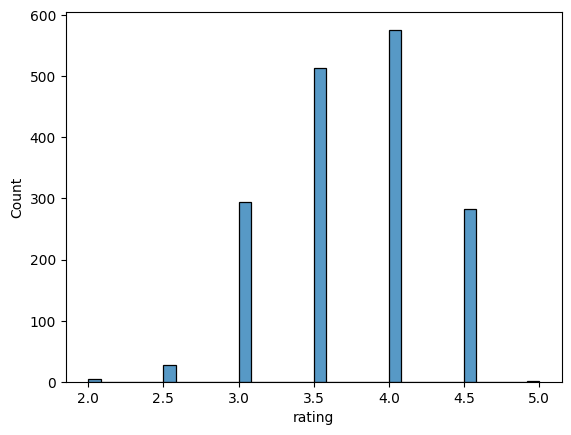

In [278]:
# Numeric value distribution
sns.histplot(join_df['rating'])
plt.show()
# skewed to the left

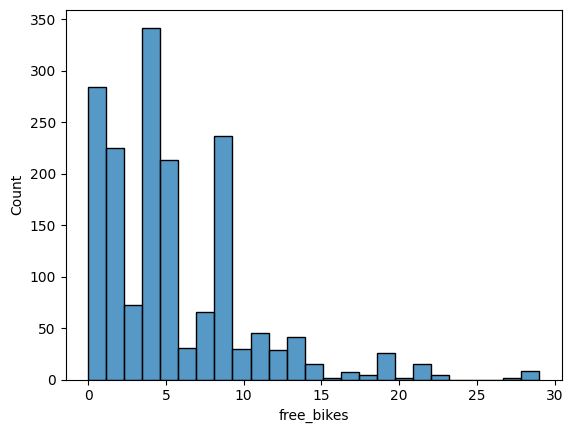

In [277]:
sns.histplot(join_df['free_bikes'])
plt.show()

# skewed to the right

<Axes: xlabel='price', ylabel='count'>

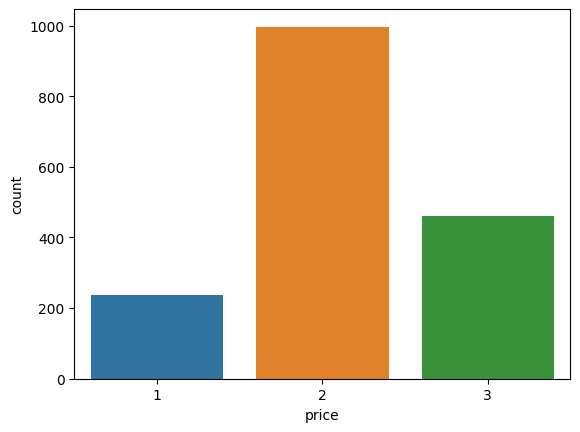

In [340]:
sns.countplot(x='price', data=join_df)

In [288]:
# Shapiro-Wilk's normality test

stat, p = stats.shapiro(join_df['rating'])
#print(p)
if p > 0.05:
    print ('%0.60f' % p, '\nNormally distributed')
else: 
    print ('%0.60f' % p, '\nReject the H0, not noramlly distributed')
#print('%0.60f' % p)

0.000000000000000000000000000000253599435024648106429413586185 
Reject the H0, not noramlly distributed


In [287]:
# Shapiro-Wilk's normality test

stat, p = stats.shapiro(join_df['free_bikes'])
#print(p)
if p > 0.05:
    print ('%0.60f' % p, '\n normally distributed')
else: 
    print ('%0.60f' % p, '\nReject the H0, not noramlly distributed')
#print('%0.60f' % p)

0.000000000000000000000000000000000001945340732508725253458179 
Reject the H0, not noramlly distributed


In [307]:
# Shapiro-Wilk's normality test

stat, p = stats.shapiro(join_df['price'])
#print(p)
if p > 0.05:
    print ('%0.60f' % p, '\n normally distributed')
else: 
    print ('%0.60f' % p, '\nReject the H0, not noramlly distributed')
#print('%0.60f' % p)

0.000000000000000000000000000000000000000001010336192778193108 
Reject the H0, not noramlly distributed


In [325]:
#new=join_df.groupby('postCode')
#new.first()

,free_bikes,city,rating,category,price,street
postCode,,,,,,
M3H5S7,3,North York,2.5,Europe,3,Dufferin Street
M3J1P3,4,Toronto,4.0,American,1,Keele Street
M3J3K2,11,North York,3.0,American,2,Finch Avenue W
M4C1J4,2,Toronto,4.0,Bars,1,Danforth Avenue
M4C1L7,9,Toronto,4.0,American,1,Danforth avenue
...,...,...,...,...,...,...
M6R2N1,12,Toronto,3.5,Cafe,2,Roncesvalles Avenue
M8V1K6,14,Etobicoke,4.0,Bars,2,Lake Shore Boulevard W
M8Y1J2,10,Etobicoke,3.5,Europe,2,The Queensway


In [350]:
#new.get_group('M3J1P3')

In [310]:
# Independence test
contingency1 = pd.crosstab(join_df['category'], join_df['price'])
contingency1

price,1,2,3,4
category,,,,
African,0,2,0,0
American,36,29,86,2
Asian,10,159,4,0
Bars,15,119,2,0
Cafe,25,198,116,0
Europe,0,200,96,0
Fancy,0,1,60,0
FastFood,144,282,91,0
MiddleEast,8,9,6,0


In [317]:
# let's try to remove the African category because it's only has two items, also we can remove v.expensive price

join_df.drop(join_df[join_df['category'] == 'African'].index, inplace=True)
join_df.drop(join_df[join_df['price'] == 4].index, inplace=True)

In [328]:
contingency2 = pd.crosstab(join_df['postCode'], join_df['price'])
contingency2

price,1,2,3
postCode,,,
M3H5S7,0,0,2
M3J1P3,30,30,0
M3J3K2,6,12,0
M4C1J4,15,0,0
M4C1L7,5,15,0
...,...,...,...
M6R2N1,0,10,0
M8V1K6,0,1,0
M8Y1J2,1,1,0


In [319]:
stat, p, dof, expected = stats.chi2_contingency(contingency1)
if p > 0.05:
    print ('%0.60f' % p, '\n independent')
else: 
    print (p, '\nReject the H0, not independent')

7.22060442236009e-109 
Reject the H0, not independent


In [329]:
stat, p, dof, expected = stats.chi2_contingency(contingency2)
if p > 0.05:
    print ('%0.60f' % p, '\n independent')
else: 
    print (p, '\nReject the H0, not independent')

2.0123722709171796e-81 
Reject the H0, not independent


In [320]:
Inex_rat= join_df[join_df['price']==1]['rating']
mod_rat = join_df[join_df['price']==3]['rating']
exp_rat = join_df[join_df['price']==2]['rating']
#vexp_rat = join_df[join_df['price']==4]['rating']
print(Inex_rat.mean(), exp_rat.mean(), mod_rat.mean())

4.050420168067227 3.679037111334002 3.6767895878524945


<Axes: xlabel='price', ylabel='count'>

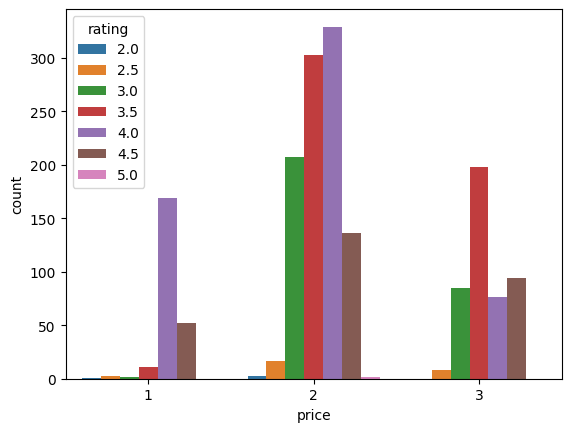

In [341]:
sns.countplot(x='price', hue='rating', data=join_df)

In [357]:
join_df.head()

,free_bikes,postCode,city,rating,category,price,street
0,16,M4L1E2,1,4.0,1,1,Queen Street E
2,14,M4M1Y5,1,4.5,2,2,Gerrard Street E
4,6,M6G2N3,1,4.0,1,2,Vaughan Road
28,0,M4T2S9,1,3.0,4,2,Yonge Street
32,29,M5V4A6,1,3.5,1,2,Fort York Blvd


# Database

Put all your results in an SQLite3 database (remember, SQLite stores its databases as files in your local machine - make sure to create your database in your project's data/ directory!)

Look at the data before and after the join to validate your data.

In [358]:
import sqlite3

table_name = 'JoinDF'

conn = sqlite3.connect('data\project2.db')
query = f'Create table if not Exists {table_name} (free_bikes int, postCode text, city int, ratingsq)'
